<img src="https://basketballnoise.com/wp-content/uploads/2020/12/2f0e742ab5cc498c6159788c2ecb290a.jpg" width=65%>

# NBA Salary Model

Each free agency period marks the coronation of a new "highest paid player" in the NBA. This is due to a number of factors - a perpetually rising salary cap, a competitive open market, and a product that is <a href="https://fadeawayworld.net/nba-media/basketball-named-3rd-most-popular-sport-in-the-world-with-over-2-billion-fans-worldwide">growing in popularity</a> all over the world.

But what if all these economic factors were secondary, and the best players still earn the most money?

This notebook will attempt to model players on-court statistics as predictors of their annual salary.

In [1]:
# Base imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read in stats and salary data (see: ./scrape_salaries.py)
nba = pd.read_csv('./advanced_stats_and_salaries.csv')
nba.head()

,Player,Pos,Age,Tm_x,G,GS,MP,FG,FGA,FG%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary
0,Aaron Gordon,PF,26,DEN,70,70,31.4,5.7,11.1,0.512,...,19.9,2.8,1.9,4.7,0.103,0.3,-1.1,-0.8,0.7,"$16,409,091"
1,Aaron Holiday,PG,25,TOT,58,14,16.4,2.5,5.3,0.468,...,18.3,0.7,0.9,1.6,0.079,-1.6,0.4,-1.2,0.2,"$3,980,551"
2,Aaron Nesmith,SF,22,BOS,48,3,11.1,1.3,3.5,0.386,...,16.8,-0.4,0.8,0.4,0.034,-5.1,0.7,-4.4,-0.3,"$3,631,200"
3,Aaron Wiggins,SG,23,OKC,47,32,23.9,3.0,6.6,0.463,...,14.9,0.5,0.8,1.3,0.055,-3.3,-0.7,-4.1,-0.6,"$1,000,000"
4,Abdel Nader,SF,28,PHO,14,0,10.4,0.9,2.5,0.343,...,15.0,-0.3,0.3,0.0,-0.008,-7.0,2.2,-4.8,-0.1,"$2,000,000"


--------

## Feature Cleaning

Before we can begin a modeling pipeline, we'll have to clean our features to minimize multicollinearity and variance inflation

In [2]:
# Unique positions in datatset
nba['Pos'].unique()

array(['PF', 'PG', 'SF', 'SG', 'C', 'SG-PG', 'C-PF', 'SG-SF', 'PG-SG',
       'SF-SG', 'PF-SF'], dtype=object)

In [3]:
# Drop non-essential categorical features
nba = nba.drop(columns=['Player', 'Tm_x'])

def derive_salary(x):
    # Transforms $450,000 to 450000
    temp = x.strip().replace('$', '').replace(',', '')
    return int(temp)

def clean_position(x):
    # We'll streamline players positions by defaulting to their first listed position
    return x.split('-')[0]

def frontcourt(x):
    # Frontcourt players == Centers and Power Forwards (traditionally speaking)
    # We'll binarize players' positions here to reduce the load on our model
    if x in ['C', 'PF']:
        return 1
    return 0

# Clean salary values
nba['Salary'] = nba['Salary'].apply(lambda x: derive_salary(x))

# Clean position values
nba['Pos'] = nba['Pos'].apply(lambda x: clean_position(x))

# Binarize player position
nba['frontcourt_player'] = nba['Pos'].apply(lambda x: frontcourt(x))

# Drop multi-level position feature
nba.drop(columns=['Pos'], inplace=True)

# Reorder columns so that Salary is the first feature (for ease in a minue)
output_columns = [x for x in nba.columns if x != 'Salary']
reordered = ['Salary'] + output_columns
nba = nba.loc[:, reordered]

nba.head()

,Salary,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,frontcourt_player
0,16409091,26,70,70,31.4,5.7,11.1,0.512,1.1,3.4,...,19.9,2.8,1.9,4.7,0.103,0.3,-1.1,-0.8,0.7,1
1,3980551,25,58,14,16.4,2.5,5.3,0.468,0.6,1.6,...,18.3,0.7,0.9,1.6,0.079,-1.6,0.4,-1.2,0.2,0
2,3631200,22,48,3,11.1,1.3,3.5,0.386,0.5,2.1,...,16.8,-0.4,0.8,0.4,0.034,-5.1,0.7,-4.4,-0.3,0
3,1000000,23,47,32,23.9,3.0,6.6,0.463,0.9,2.7,...,14.9,0.5,0.8,1.3,0.055,-3.3,-0.7,-4.1,-0.6,0
4,2000000,28,14,0,10.4,0.9,2.5,0.343,0.3,1.0,...,15.0,-0.3,0.3,0.0,-0.008,-7.0,2.2,-4.8,-0.1,0


Analysis

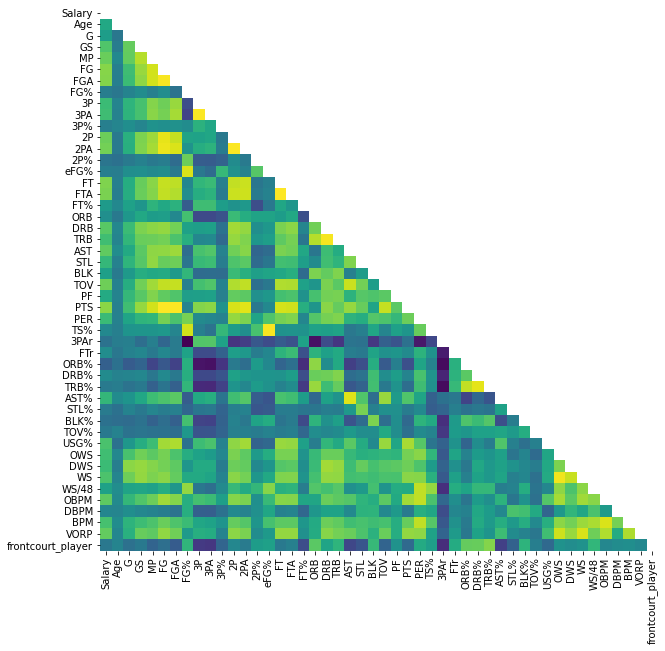

In [4]:
# Correlation matrix of numeric data types
nba_corr = nba.select_dtypes([np.number]).corr()

# Define upper triangle 
mask = np.triu(nba_corr)

# Plot heatmap
plt.figure(figsize=(10,10))
sns.heatmap(nba_corr, mask=mask, linewidths=0, 
            cmap='viridis', cbar=False)
plt.show()

Some of these features are inherently multicollinear - e.g., 2-point shots made and 2-point shots attempted - so we'll drop the attempts and only keep the shots that registered points. Similarly, `TRB` is an aggregate measure of `ORB` and `DRB` - we'll keep the individual measures. `eFG%` and `TS%` are relatively congruent, except the latter includes free throws. We'll drop `eFG%` for this reason.

We'll repeat the steps above to make sure we're on the right track.

In [5]:
# Drop features mentioned above
collinear_features = ['FGA', '2PA', '3PA', 'FTA', 'TRB', 'eFG%']
nba.drop(columns=collinear_features, inplace=True)

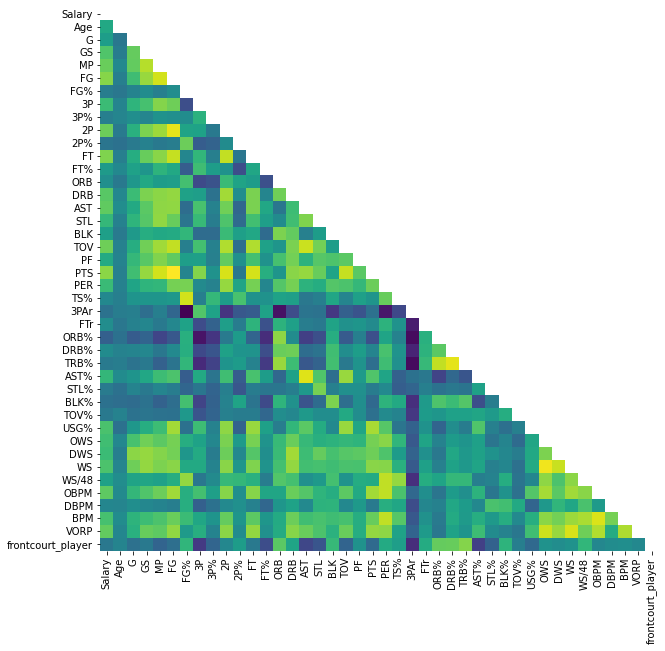

In [6]:
# Repeat previous steps
nba_corr = nba.select_dtypes([np.number]).corr()
mask = np.triu(nba_corr)

plt.figure(figsize=(10,10))
sns.heatmap(nba_corr, mask=mask, linewidths=0, 
            cmap='viridis', cbar=False)
plt.show()

Much better!

Let's check the breakdown of Backcourt and Frontcourt players (keeping in mind that the Backcourt category contains three position groups while the Frontcourt category contains two).

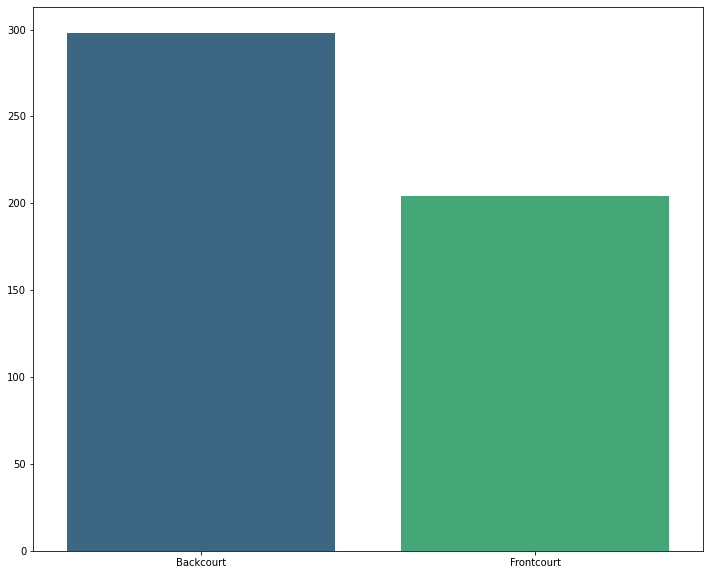

In [7]:
plt.figure(figsize=(12,10))
g=sns.countplot(data=nba, x='frontcourt_player', palette='viridis')
g.set_xticklabels(['Backcourt', 'Frontcourt'])
plt.xlabel('')
plt.ylabel('')
plt.show()

No major imbalance to speak of!

Lastly, we'll take a look at missing values in this dataset. We'll end up imputing these in the modeling process, but it's best to make sure there isn't a systematic data loss before we get there.

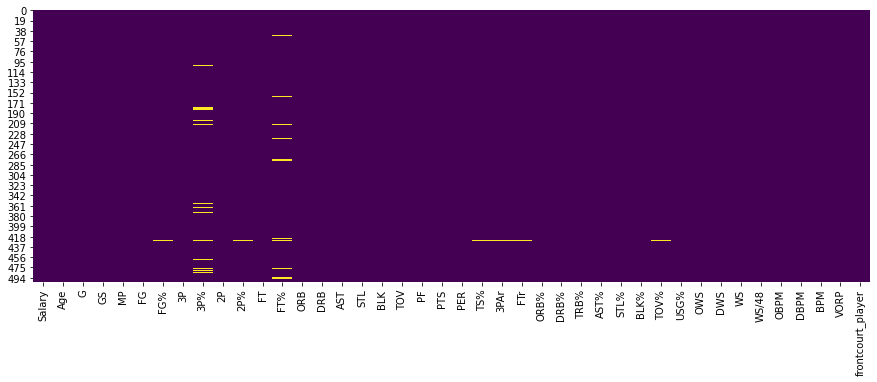

In [8]:
plt.figure(figsize=(15,5))
sns.heatmap(nba.isnull(), cmap='viridis', cbar=False)
plt.show()

We're in good shape! No systematic missing data to report.

Looks like we're all set to move on to the modeling stage!

--------------

## LASSO Pipeline

We'll use a `LASSO` approach here to deal with any latent multicollinearity in our remaining features. After optimizing the alpha parameter in our model, we'll fit a `Pipeline` object with several preprocessing tools and assess the performance of our `LASSO` model.

In [9]:
# Modeling imports
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

In [10]:
# Isolate features
features = nba.iloc[:, 1:]

# Isolate player salaries
salaries = nba.iloc[:, 0]

# Split data into training and testing components (33% test size)
X_train, X_test, y_train, y_test = train_test_split(features, salaries, test_size=0.33, random_state=101)

In [11]:
steps = [
    # SimpleImputer to fill missing observations
    ('impute', SimpleImputer(strategy='mean')),
    
    # StandardScaler to mean-center features
    ('scale', StandardScaler()),
    
    # LASSO to predict outcomes in out-of-sample data
    ('model', Lasso(alpha=0.95, max_iter=1000000000, tol=.001))
]

# We'll wrap the steps above in a Pipeline object
pipe = Pipeline(steps)

# Fit to training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('impute', SimpleImputer()), ('scale', StandardScaler()),
                ('model', Lasso(alpha=0.95, max_iter=1000000000, tol=0.001))])

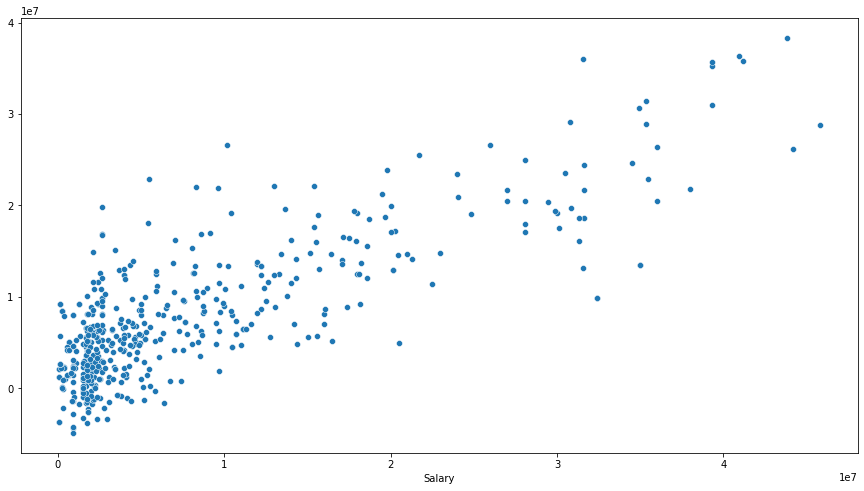

In [12]:
# Derived values from model
preds = pipe.predict(X_test)

# Plot correlation of real / predicted values
plt.figure(figsize=(15,8))
g=sns.scatterplot(x=salaries, y=pipe.predict(features))
#g.set_xticks([f'${int(x)}'for x in g.get_xticks()])
plt.show()

----------

## Analysis

In [13]:
# Predict values and add to global dataframe
nba['predicted_vals'] = pipe.predict(nba.iloc[:, 1:])

def pay_to_play(df):
    return df['Salary'] > df['predicted_vals']

# Determine which players are paid more than our model predicts
nba['overpaid'] = nba.apply(pay_to_play, axis=1)

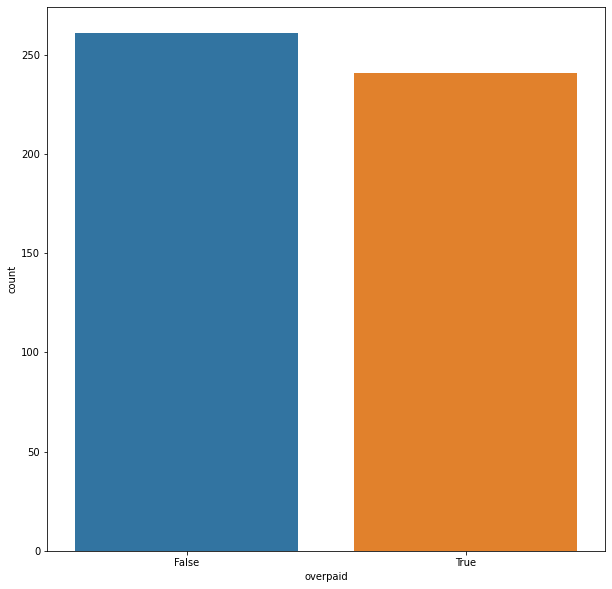

In [14]:
# Plot breakdown of "overpaid" players derived from our model
plt.figure(figsize=(10,10))
sns.countplot(data=nba, x='overpaid')
plt.show()

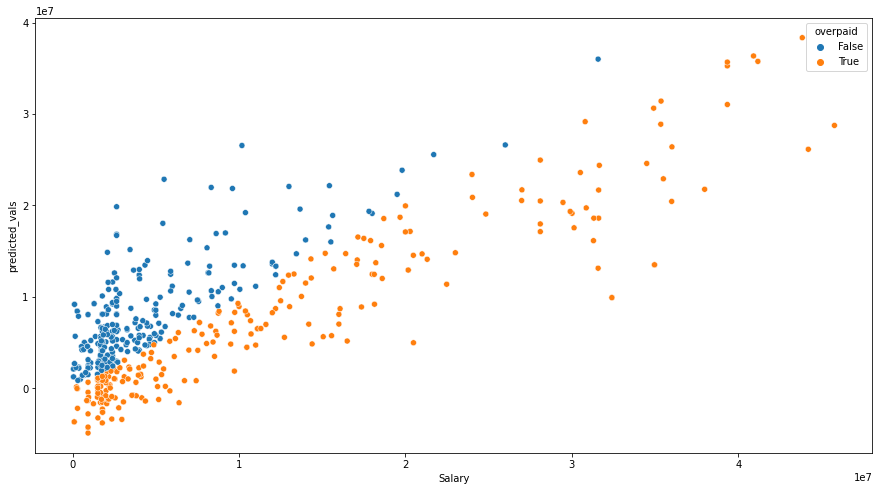

In [15]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=nba, x='Salary', y='predicted_vals', hue='overpaid')
plt.show()

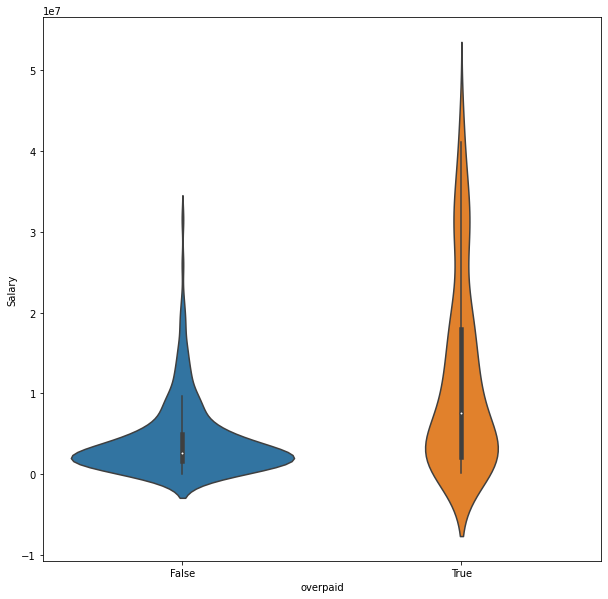

In [16]:
plt.figure(figsize=(10,10))
sns.violinplot(data=nba, x='overpaid', y='Salary')
plt.show()